torch.Size([50, 2, 224, 224])
torch.Size([50, 1, 224, 224])
torch.Size([50, 3, 224, 224])
255
20


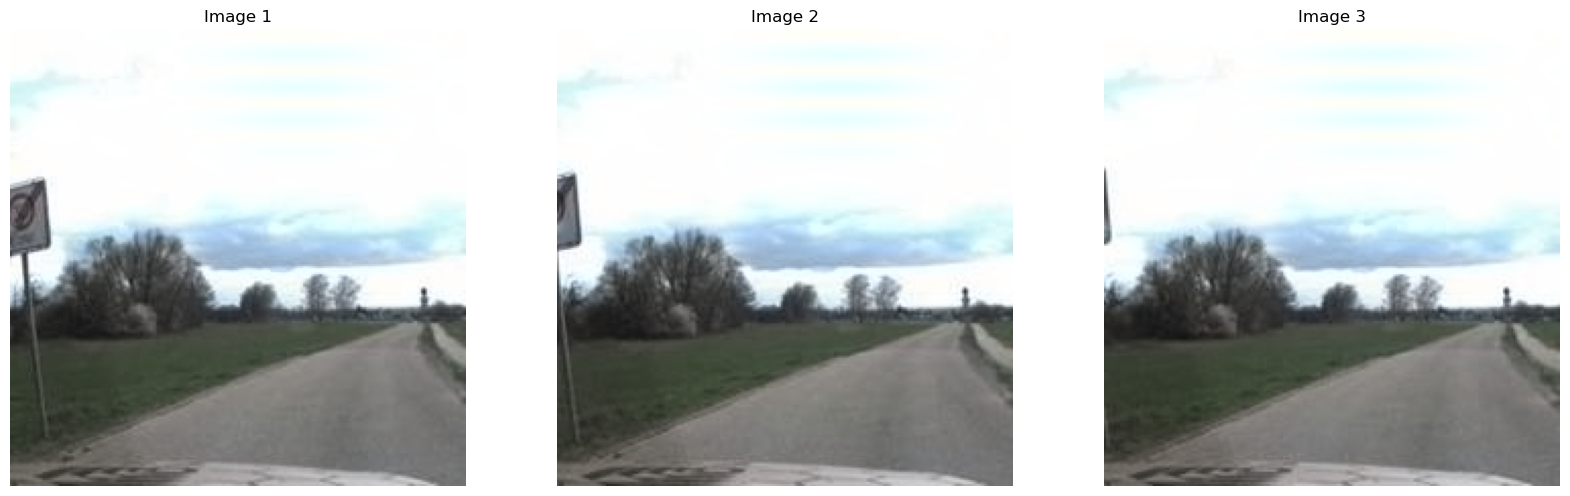

In [7]:
from datasets import ColorizationDataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from models import DeepLabV3ResNet50
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

device = "cpu"

if torch.backends.mps.is_available():
    device = torch.device("mps")

dataset = ColorizationDataset(transform=transform, use_test=True)

dataloader = DataLoader(
    dataset, batch_size=50, shuffle=False, num_workers=4, pin_memory=True)

model = DeepLabV3ResNet50(2).to(device)
model.load_state_dict(torch.load("models/ResNet_0.0001_8_6.pth"))

model.eval()
with torch.no_grad():
    x = next(iter(dataloader))
    x = x.to(device)
    y_pred = model(x.expand(3, -1, -1, -1).permute(1, 0, 2, 3))
    y_pred = y_pred["out"]
    x = (x.cpu() + 1) * 50.0
    x = x.unsqueeze(1)
    print(y_pred.shape)
    print(x.shape)
    y_pred = y_pred.cpu() * 110.0
    y_pred = torch.concat([x, y_pred], dim=1)
    print(y_pred.shape)
    y_pred = lab2rgb(y_pred.cpu().numpy().transpose(0, 2, 3, 1))    
    y_pred = y_pred * 255
    y_pred = y_pred.astype(np.uint8)
    y_pred = np.clip(y_pred, 0, 255)
    np.save("prediction.npy", y_pred)
    
    print(y_pred[0].max())
    print(y_pred[0].min())

    image0 = to_pil(y_pred[0])
    image1 = to_pil(y_pred[1])
    image2 = to_pil(y_pred[2])
    
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(image0)
    plt.title("Image 1")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(image1)
    plt.title("Image 2")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(image2)
    plt.title("Image 3")
    plt.axis("off")
    
    plt.show()